<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/CNN_classifier_on_remote_sensing_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN classifier for landcover classification from remote sensing images

In this tasks, we will again use the same portion of the [SAT-6](https://csc.lsu.edu/~saikat/deepsat/) dataset from Louisiana State University and NASA Ames Research Center.

In this notebook, we will make use of small CNN network on the same subset of SAT-6 dataset that we used in the last exercise

In [1]:
# CNN classifier for landcover classification
# Author: Ankit Patnala, JSC, 2025
# Download necessary packages if right kernel is not present
# Not needed in colab
#!pip install pandas
#!pip install scikit-learn
#!pip install matplotlib

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm

## Obtaining the data
The data is available via this B2share link [link](https://b2share.eudat.eu/records/89654eac10724d30a6c7e51f2c5422de). Download all the files at the same folder path where you are creating this notebook

Alternatively use the following wget commands to download the data

The following cell can be executed in Google colab

In [3]:
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/X_test_sat6.csv
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/y_test_sat6.csv
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/sat6annotations.csv

--2025-05-27 14:06:23--  https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/X_test_sat6.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving b2share.eudat.eu (b2share.eudat.eu)... 86.50.166.97
Connecting to b2share.eudat.eu (b2share.eudat.eu)|86.50.166.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 905628829 (864M) [text/plain]
Saving to: ‘X_test_sat6.csv’

X_test_sat6.csv     100%[===================>] 863,67M  5,79MB/s    in 2m 30s  

2025-05-27 14:08:53 (5,75 MB/s) - ‘X_test_sat6.csv’ saved [905628829/905628829]

--2025-05-27 14:08:53--  https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/y_test_sat6.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving b2share.eudat.eu (b2share.eudat.eu)... 86.50.166.97
Connecting to b2share.eudat.eu (b2share.eudat.eu)|86.50.166.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 972000 (949K) [text/plain]
Saving to

In [4]:
# load the csv file with the image data. Each row belongs to one sample. Each sample has 3136 columns i.e. 4 channels (R,G,B, and NIR) and 28 \times 28 spatial size
landcover_df = pd.read_csv("./X_test_sat6.csv",header=None)
landcover_df

,0,1,2,3,4,5,6,7,8,9,...,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135
0,95,91,61,157,105,113,101,179,50,35,...,107,181,118,137,127,205,90,105,86,183
1,102,102,103,137,108,110,116,154,88,83,...,91,157,95,92,84,143,89,85,76,130
2,47,54,95,10,79,89,108,15,96,131,...,118,17,82,98,125,18,61,69,113,13
3,200,181,178,218,192,177,176,214,162,141,...,139,203,157,138,125,193,147,128,107,187
4,85,101,100,15,87,102,97,16,54,71,...,74,8,37,49,76,6,27,43,69,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80995,82,82,115,17,104,123,131,23,100,119,...,146,32,137,152,159,44,159,166,166,61
80996,170,148,147,174,203,188,163,190,211,197,...,134,172,163,154,136,175,172,157,143,177
80997,140,136,126,190,156,163,152,208,152,170,...,126,162,93,111,119,170,68,66,61,123
80998,89,87,99,13,64,66,89,9,16,26,...,111,15,49,52,97,11,47,56,102,9


# Read annotation labels from different csv file

In [5]:
# Read the annotation file to get the annotation i.e. classname corresponding to the labels
annotations = pd.read_csv("./sat6annotations.csv", header=None)
print(annotations)
labels = annotations[0].values
print(f'class labels: {labels}')

             0  1  2  3  4  5  6
0     building  1  0  0  0  0  0
1  barren_land  0  1  0  0  0  0
2        trees  0  0  1  0  0  0
3    grassland  0  0  0  1  0  0
4         road  0  0  0  0  1  0
5        water  0  0  0  0  0  1
class labels: ['building' 'barren_land' 'trees' 'grassland' 'road' 'water']


**Reminder :**  The data structure that you see above is called _one-hot encoding_


In [6]:
# load the csv file with the labels of all samples
labels_df = pd.read_csv("./y_test_sat6.csv",header=None)
print(labels_df)
# get the names of the class labels (here, only "0" to "5")
# These correspond to the labels printed above
column_names = labels_df.columns.values

       0  1  2  3  4  5
0      0  0  1  0  0  0
1      0  0  1  0  0  0
2      0  0  0  0  0  1
3      0  1  0  0  0  0
4      0  0  0  0  0  1
...   .. .. .. .. .. ..
80995  0  0  0  0  0  1
80996  0  1  0  0  0  0
80997  0  0  1  0  0  0
80998  0  0  0  0  0  1
80999  0  0  1  0  0  0

[81000 rows x 6 columns]


# Plot random samples for illustration

&#x1F479; _Task:_ Plot few samples to see visually the data and gain more insights on how to reshape the 1d data to a 4 channel image (RGB & NIR)

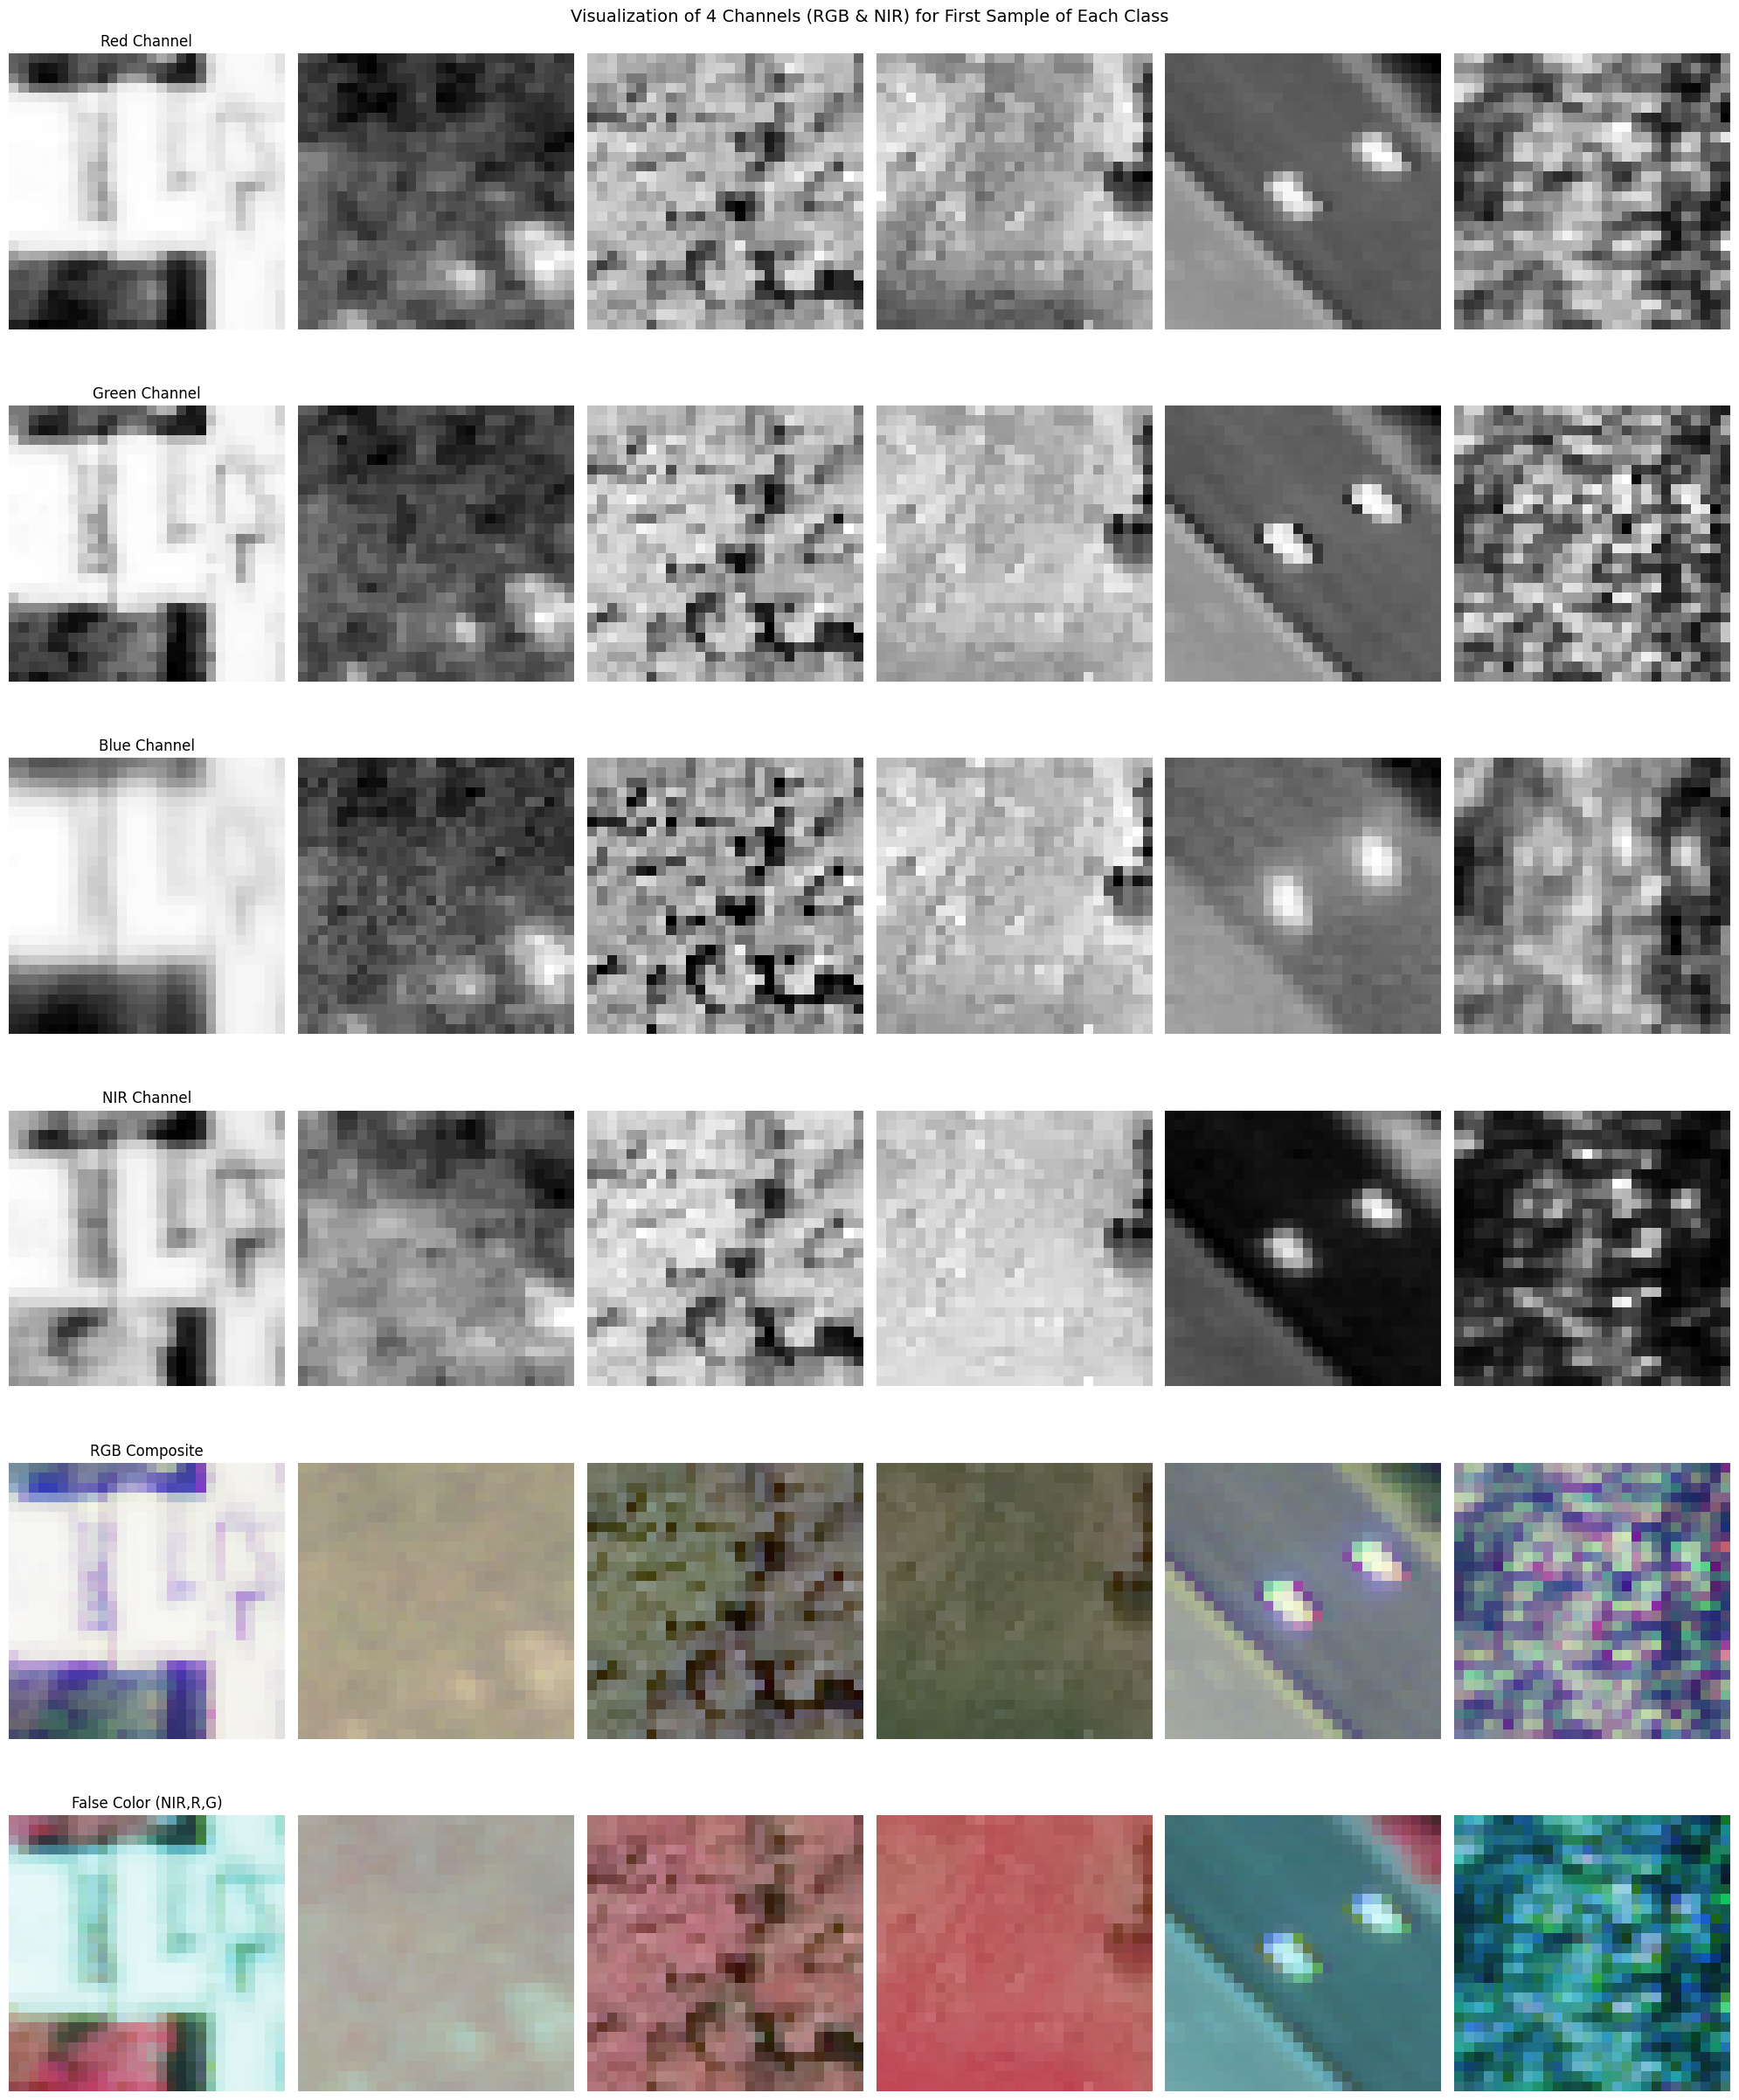

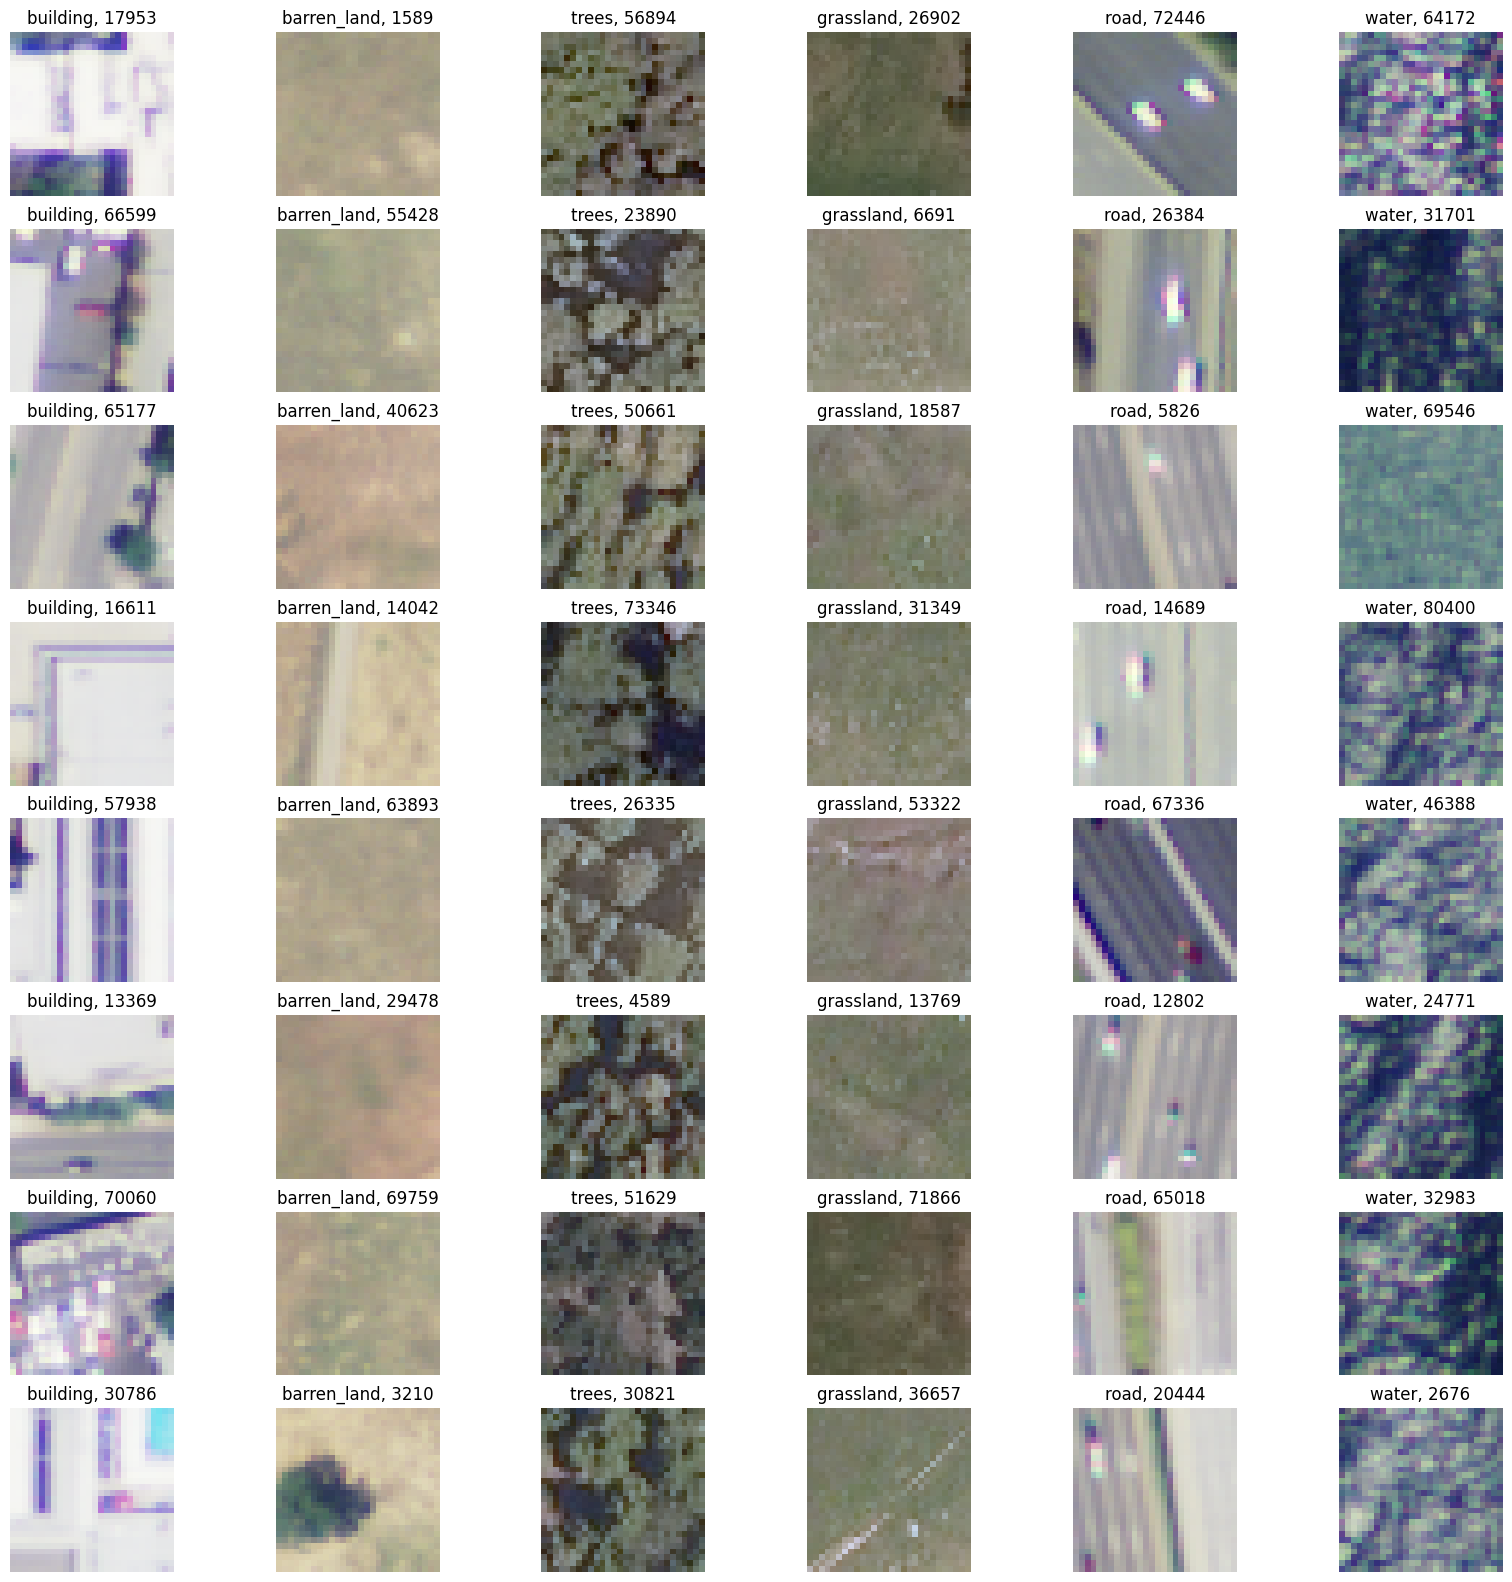

In [27]:
num_classes = len(column_names)
num_samples = 8  # number of rows to plot
sample_idx = []
for column in column_names:
    # find all indices of a given class
    class_idx = labels_df[column] == 1
    # randomly select num_samples from this index list - make sure to avoid duplicates
    sample_idx.append(np.random.choice(np.where(class_idx.values)[0], size=num_samples, replace=False).tolist())

#### Plot individual channels
fig2, axes = plt.subplots(6, 6, figsize=(20, 25))
fig2.suptitle('Visualization of 4 Channels (RGB & NIR) for First Sample of Each Class', fontsize=14)

for class_idx in range(6):
    # Take first sample from each class
    example_idx = sample_idx[class_idx][0]
    data_1d = landcover_df.iloc[example_idx].values
    data_4d = np.reshape(data_1d, (-1, 28, 28, 4))[0]

    # Plot individual channels
    channels = ['Red', 'Green', 'Blue', 'NIR']
    for i, channel in enumerate(channels):
        axes[i, class_idx].imshow(data_4d[..., i], cmap='gray')
        if class_idx == 0:  # Only show channel names for first column
            axes[i, class_idx].set_title(f'{channel} Channel')
        if class_idx == 5:  # Show class label for last column
            axes[i, class_idx].set_ylabel(labels[class_idx])
        axes[i, class_idx].axis('off')

    # Plot RGB composite (simply combine r,g,b channels)
    axes[4, class_idx].imshow(data_4d[..., :3])
    if class_idx == 0:
        axes[4, class_idx].set_title('RGB Composite')
    axes[4, class_idx].axis('off')

    # Plot false color (NIR,R,G), such that:
    # - Vegetation is bright red (see NIR channel mapped to R, per convention since this dataset is for agriculture focus, healthy vegetation must pop out in the image)
    # - Urban areas/soil is blue-gray (but can be very distinct)
    # - Water is extremely dark, as it absorbes NIR information (almost no intensity)
    false_color = np.dstack((data_4d[..., 3], data_4d[..., 0], data_4d[..., 1]))
    axes[5, class_idx].imshow(false_color)
    if class_idx == 0:
        axes[5, class_idx].set_title('False Color (NIR,R,G)')
    axes[5, class_idx].axis('off')

plt.tight_layout()
####

fig, ax = plt.subplots(num_samples, num_classes, figsize=(20,20))
for i in range(num_samples):
    for j in range(num_classes):
        data_index = sample_idx[j][i]
        ax[i,j].set_title(f"{labels[j]}, {data_index}")
        ax[i,j].axis('off')
        data = np.reshape(landcover_df.iloc[data_index].values,(-1,28,28,4))
        ax[i,j].imshow(data[0,...,:3])

### Create the training and test datasets

The dataset is not balanced. Use ***num_train*** and ***num_test*** as a definite integer number.

Note: the maximum we tried is ***num_train*** = 2000 and ***num_test*** = 200. Beyond that for some classes, we did not find that many samples

In case you want all samples for training then use ***num_train*** = -1

In [28]:
num_train = 1000 #replace with -1 if all samples need to be used for training
num_test = 100
train_idx = []
test_idx = []
for column in column_names:
    # find all indices of a given class
    class_idx = labels_df[column] == 1
    # randomly select num_train and num_test values from this index list - make sure to avoid duplicates
    valid_indices = np.where(class_idx.values)[0]
    random_indices = np.random.permutation(valid_indices)
    test_idx.extend(random_indices[:num_test])
    train_idx.extend(random_indices[num_test:num_test+num_train if num_train != -1 else num_train])
print(f'number of train indices: {len(train_idx)}, number of test indices: {len(test_idx)}')


number of train indices: 6000, number of test indices: 600


In [29]:
# Extract images and labels corresponding to the selected indices
train_X = landcover_df.iloc[train_idx]
train_y = labels_df.iloc[train_idx]
test_X = landcover_df.iloc[test_idx]
test_y = labels_df.iloc[test_idx]

# Calculate Normalization Parameter using Train Dataset

In [30]:
train_X_reshape = train_X.values.reshape((-1,28,28,4))
mean_per_channels = np.mean(train_X_reshape,axis=(0,1,2)).astype(np.float32)
std_per_channels = np.std(train_X_reshape,axis=(0,1,2)).astype(np.float32)
mean_per_channels, std_per_channels

(array([132.21489, 132.3411 , 129.4108 , 120.80735], dtype=float32),
 array([55.308964, 50.851727, 46.907223, 65.770195], dtype=float32))

## Define torch dataset

From here, we will make use of general workflow of PyTorch. First thing is to create a dataset. We are making use of mapped-style dataset. [Refer this page for more details](https://pytorch.org/docs/stable/data.html#map-style-datasets)

Important thing is to define the total length under dunder function *__len__* and data corresponding to the index under *__getitem__*

In [31]:
class SAT6Dataset(Dataset):
  def __init__(self,data_df,label_df, normalization_parameter):
    super(SAT6Dataset,self).__init__()
    self.data_df = data_df
    self.label_df = label_df
    self.normalization = normalization_parameter

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self,idx):
    data = self.data_df.iloc[idx].values.reshape((28,28,4)).astype(np.float32)
    data = (data-self.normalization[0])/self.normalization[1]
    #data = data/255.0
    data = np.transpose(data,axes=(2,0,1))
    label = self.label_df.iloc[idx].values
    label_args = np.where(label==1)[0]

    return (data,label_args[0])

In [32]:
# define two dataset one for train and other for test
sat6_train_dataset = SAT6Dataset(train_X,train_y,(mean_per_channels,std_per_channels))
sat6_test_dataset = SAT6Dataset(test_X,test_y,(mean_per_channels,std_per_channels))

Now, we will use **torch.nn.Module** to build our CNN model.

**Important points:**

*   To build modules in a list use **torch.nn.ModuleList()** instead of native list.

*   Define **forward** function to define the step-byt-by mathematical transformation




In [33]:
class CNN(torch.nn.Module):
  def __init__(self,
               input_shape,
               num_conv_layers,
               channels_each_layer,
               kernel_size,
               mlp_dimension,
               activation_func,
               pooling,
               input_channels,
               num_classes,
               norm="batch_norm"):
    super(CNN,self).__init__()
    self.num_conv_layers = num_conv_layers
    self.channels_each_layer = channels_each_layer
    assert num_conv_layers == len(channels_each_layer),"Number of conv layers does not match with length of channels given"
    self.kernel_size = ([kernel_size] * num_conv_layers
                        if type(kernel_size) == int
                        else kernel_size)
    self.mlp_dimension = mlp_dimension
    if activation_func == 'relu':
      self.activation_func = torch.nn.ReLU()
    elif activation_func == 'tanh':
      self.activation_func = torch.nn.Tanh()
    else:
      assert False, "Currently only relu and tanh are provided in this code"

    if pooling == "max":
      self.pooling = torch.nn.AvgPool2d(kernel_size=2, stride=2)
    else:
      self.pooling = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    self.input_channels = input_channels
    if norm=="batch_norm":
      self.batch_norms = [torch.nn.BatchNorm2d(channels_each_layer[i])
                          for i in range(len(self.kernel_size))]
    elif norm == "identity":
      self.batch_norms = [torch.nn.Identity() for i in range(len(self.kernel_size))]
    else:
      assert False,"only batch norm is provided in this code"

    self.conv_modules = torch.nn.ModuleList()

    for i in range(num_conv_layers):
      self.conv_modules.append(
          torch.nn.Conv2d(input_channels if i==0 else channels_each_layer[i-1],
                          channels_each_layer[i],
                          self.kernel_size[i],
                          stride=1,
                          padding='same',
                          bias=True))
      self.conv_modules.append(self.batch_norms[i])
      self.conv_modules.append(self.activation_func)
      self.conv_modules.append(self.pooling)
    dim_after_final_conv_layer = (input_shape[0]//2**num_conv_layers)*(
        input_shape[1]//2**num_conv_layers)*(
            channels_each_layer[-1])
    self.mlp_layer_modules = torch.nn.ModuleList()
    self.mlp_dimension = ([mlp_dimension]
                          if type(mlp_dimension) == int
                          else mlp_dimension)

    for i in range(len(self.mlp_dimension)):
      self.mlp_layer_modules.append(
          torch.nn.Linear((dim_after_final_conv_layer
                           if i==0
                           else self.mlp_dimension[i-1]),
                          self.mlp_dimension[i]))
      # Incase one want to try batch norm uncomment below line
      #self.mlp_layer_modules.append(torch.nn.BatchNorm1d(mlp_dimension[i]))
      self.mlp_layer_modules.append(self.activation_func)
    self.mlp_layer_modules.append(
        torch.nn.Linear(self.mlp_dimension[-1],num_classes))

  def forward(self,x):
    for module in self.conv_modules:
      x = module(x)
    x = x.flatten(1)
    for module in self.mlp_layer_modules:
      x = module(x)
    return x

In [35]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                                    stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3,
                                    stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        
        # Skip connection (if dimensions change)
        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=1,
                              stride=stride, bias=False),
                torch.nn.BatchNorm2d(out_channels)
            )
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)  # Skip connection
        out = self.relu(out)
        
        return out

class MinimalResNet(torch.nn.Module):
    def __init__(self, input_channels=4, num_classes=6):
        super(MinimalResNet, self).__init__()
        
        # Initial convolution
        self.conv1 = torch.nn.Conv2d(input_channels, 64, kernel_size=7,
                                    stride=2, padding=3, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        
        # Average pooling and final classification
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(128, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        
        # Classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

Define the device (**GPU** if you use GPU as your runtime) else it will run on **CPU**)
Instatiation of the CNN model is also define in this cell

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
cnn = CNN((28,28),3,[32,64,128],[5,3,3],[32],"relu","max",4,6,norm="identity").to(device)
resnet = MinimalResNet(input_channels=4, num_classes=6).to(device)


cuda:0


In [38]:
# Overview of the models
print(cnn)
print(resnet)

CNN(
  (activation_func): ReLU()
  (pooling): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_modules): ModuleList(
    (0): Conv2d(4, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Identity()
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): Identity()
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): Identity()
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (mlp_layer_modules): ModuleList(
    (0): Linear(in_features=1152, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)
MinimalResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): 

Define training parameters


*   Optimizer : This reulates the rate of learning. USe wither adam or SGD. For other optimizers, feel free to add them.
*   Scheduler : It updates the learning rate during the training process. We have commented here out. PLease feel free to play with it.
*   Loss function: As it is a multi-class classification problem, CrossEntropy is a suitable loss function.



In [39]:
optim = "adam"
optimizer = torch.optim.Adam(cnn.parameters(),lr=0.001) if optim == "adam" else torch.optim.SGD(cnn.parameters(),lr=0.1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

Previously, we have defined dataset which takes an index as a parameter and provides data corresponding to the index. In such deep learning problems, we process them in a batch. DataLoader takes control of such requirements by defining the paraemter such as **batch_size** and **shuffle**.

**Note:**


*   In training, we want each time to have different samples in a batch. The ***shuffle*=True** ensures that. For validation, we do not required such shuffling, hence it is set to False
*   We used the whole length of test dataset as it is small. Incase of any issue with large number of test samples, feel free to decrease the number such as $256$



In [40]:
train_dataloader = DataLoader(sat6_train_dataset,batch_size=256,shuffle=True,drop_last=True)
test_dataloader = DataLoader(sat6_test_dataset,len(sat6_test_dataset), shuffle=False)

# Training Routine
Define number of epochs for the training.


In [41]:
num_epochs = 10
training_loss_per_epoch = []
validation_loss_per_epoch = []
acc_per_epoch = []

with tqdm(total=num_epochs) as pbar:
  for i in range(num_epochs):
    cnn.train()
    for train_data_idx, train_data in enumerate(train_dataloader):
      optimizer.zero_grad()
      data, labels = train_data
      data = data.to(device)
      labels = labels.to(device)
      preds = cnn(data)
      train_loss = loss_fn(preds,labels)
      train_loss.backward()
      optimizer.step()
    # uncomment incase scheduler is defined above
    #scheduler.step()
    training_loss_per_epoch.append(train_loss.item())

    cnn.eval()
    pred_labels = []
    true_labels = []
    with torch.no_grad():
      for test_data_idx, test_data in enumerate(test_dataloader):
        data, labels = test_data
        data = data.to(device)
        labels = labels.to(device)
        preds = cnn(data)
        val_loss = loss_fn(preds,labels)
        pred_labels.extend(torch.argmax(preds,dim=1).to('cpu'))
        true_labels.extend(torch.squeeze(labels).to('cpu'))
    validation_loss_per_epoch.append(val_loss.item())
    acc = accuracy_score(true_labels,pred_labels)
    acc_per_epoch.append(acc)
    pbar.set_description(f"Epoch {i+1}/{num_epochs}: training_loss : {train_loss}, validation_loss : {val_loss} and accuracy : {acc} ")



Epoch 10/10: training_loss : 0.1042739748954773, validation_loss : 0.11009500920772552 and accuracy : 0.9516666666666667 :   0%|          | 0/10 [00:08<?, ?it/s]


In [50]:
# Same lists but for ResNet
resnet_training_loss_per_epoch = []
resnet_validation_loss_per_epoch = []
resnet_acc_per_epoch = []

# Define optimizer for ResNet
resnet_optimizer = torch.optim.Adam(resnet.parameters())

with tqdm(total=num_epochs) as pbar:
    for i in range(num_epochs):
        resnet.train()
        for train_data_idx, train_data in enumerate(train_dataloader):
            resnet_optimizer.zero_grad()
            data, labels = train_data
            data = data.to(device)
            labels = labels.to(device)
            preds = resnet(data)
            train_loss = loss_fn(preds, labels)
            train_loss.backward()
            resnet_optimizer.step()
        resnet_training_loss_per_epoch.append(train_loss.item())

        resnet.eval()
        resnet_pred_labels = []
        resnet_true_labels = []
        with torch.no_grad():
            for test_data_idx, test_data in enumerate(test_dataloader):
                data, labels = test_data
                data = data.to(device)
                labels = labels.to(device)
                preds = resnet(data)
                val_loss = loss_fn(preds, labels)
                resnet_pred_labels.extend(torch.argmax(preds, dim=1).to('cpu'))
                resnet_true_labels.extend(torch.squeeze(labels).to('cpu'))
        resnet_validation_loss_per_epoch.append(val_loss.item())
        acc = accuracy_score(true_labels, pred_labels)
        resnet_acc_per_epoch.append(acc)
        pbar.set_description(f"Epoch {i+1}/{num_epochs}: training_loss : {train_loss}, validation_loss : {val_loss} and accuracy : {acc} ")

Epoch 10/10: training_loss : 0.04981416091322899, validation_loss : 0.0695674866437912 and accuracy : 0.955 :   0%|          | 0/10 [00:04<?, ?it/s] 


The variables **training_loss_per_epoch**, **validation_loss_per_epoch**, and **acc_per_epoch** contains metrics after each epoch. Feel free to plot them to see how was the progress during training.

## Model Evaluation

### Training Metrics

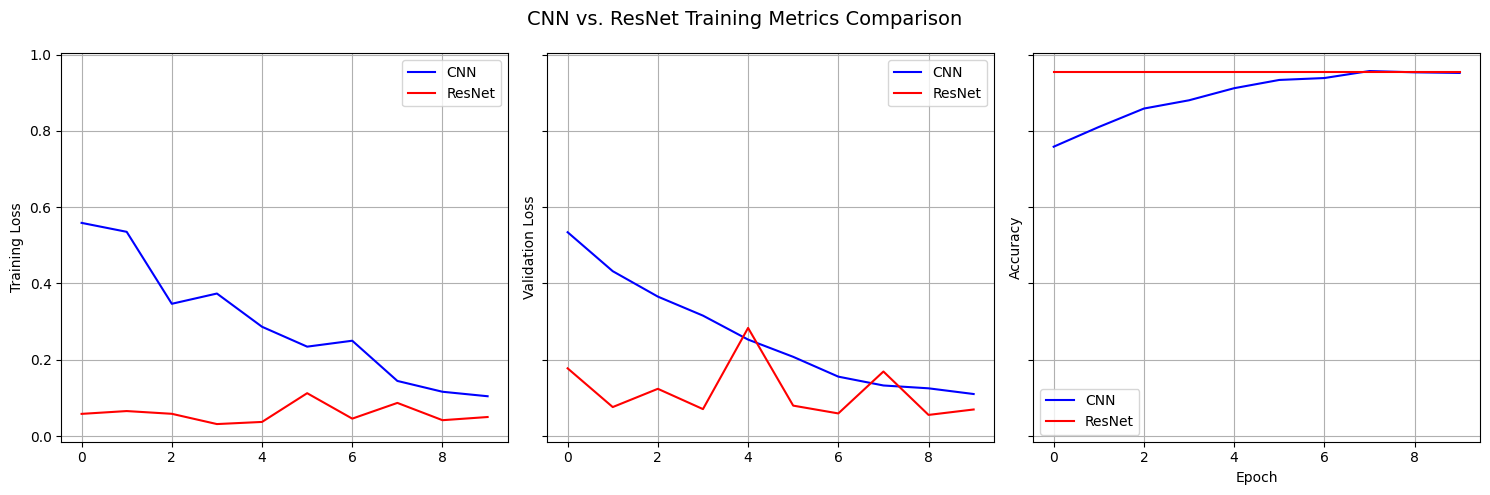

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('CNN vs. ResNet Training Metrics Comparison', fontsize=14)

# Training Loss
axes[0].plot(training_loss_per_epoch, label='CNN', color='blue')
axes[0].plot(resnet_training_loss_per_epoch, label='ResNet', color='red')
axes[0].set_ylabel('Training Loss')
axes[0].legend()
axes[0].grid(True)

# Validation Loss
axes[1].plot(validation_loss_per_epoch, label='CNN', color='blue')
axes[1].plot(resnet_validation_loss_per_epoch, label='ResNet', color='red')
axes[1].set_ylabel('Validation Loss')
axes[1].legend()
axes[1].grid(True)

# Accuracy
axes[2].plot(acc_per_epoch, label='CNN', color='blue')
axes[2].plot(resnet_acc_per_epoch, label='ResNet', color='red')
axes[2].set_ylabel('Accuracy')
axes[2].set_xlabel('Epoch')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

### Cohen's Kappa

In [54]:
from sklearn.metrics import cohen_kappa_score

# For CNN
cnn_kappa = cohen_kappa_score(true_labels, pred_labels)

# For ResNet (using the last epoch's predictions)
resnet_kappa = cohen_kappa_score(resnet_true_labels, resnet_pred_labels)

print(f"CNN Kappa Score: {cnn_kappa:.4f}")
print(f"ResNet Kappa Score: {resnet_kappa:.4f}")

CNN Kappa Score: 0.9460
ResNet Kappa Score: 0.9700


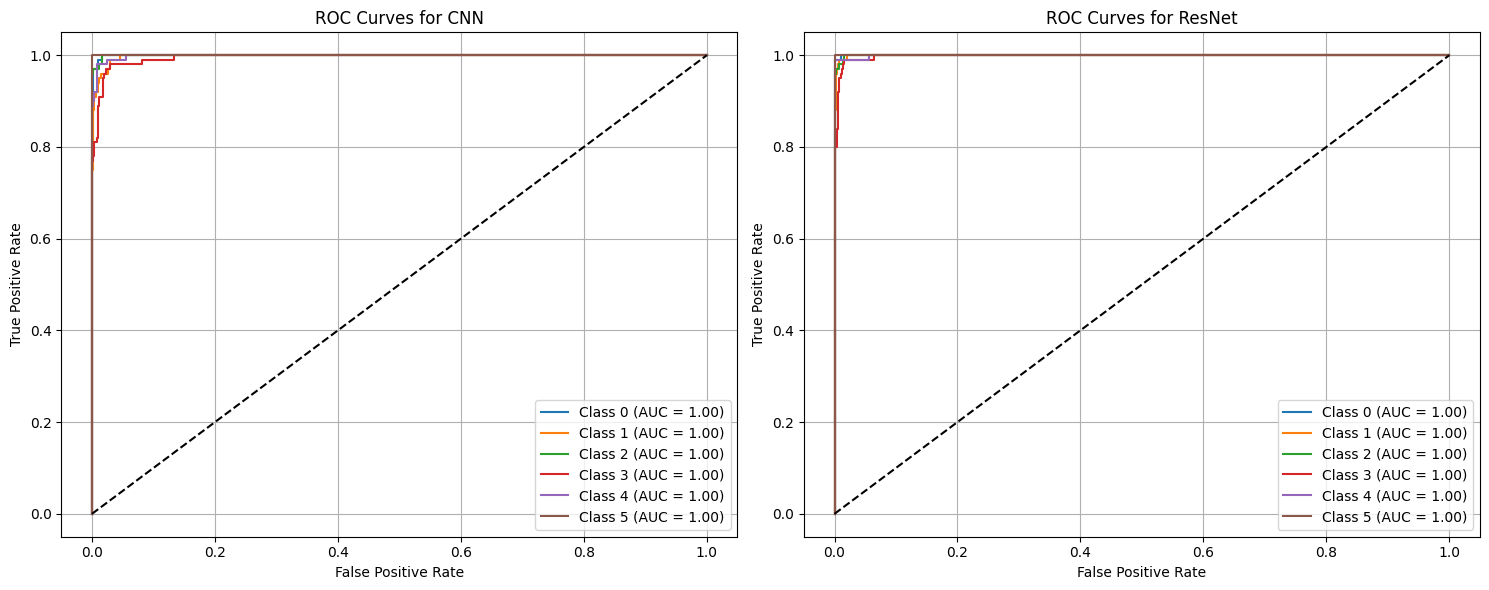

In [55]:
from sklearn.metrics import roc_curve, auc
import numpy as np

def get_roc_data(model, dataloader, device, n_classes=6):
    model.eval()
    y_scores = []
    y_true = []
    
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            # Get probability scores using softmax
            outputs = torch.nn.functional.softmax(model(data), dim=1)
            y_scores.extend(outputs.cpu().numpy())
            y_true.extend(labels.numpy())
    
    return np.array(y_scores), np.array(y_true)

# Get probability scores for both models
cnn_scores, cnn_true = get_roc_data(cnn, test_dataloader, device)
resnet_scores, resnet_true = get_roc_data(resnet, test_dataloader, device)

# Plot ROC curves
plt.figure(figsize=(15, 6))

# CNN plot
plt.subplot(1, 2, 1)
for i in range(6):
    # Binarize the labels for current class
    y_true_bin = (cnn_true == i).astype(np.int32)
    
    fpr, tpr, _ = roc_curve(y_true_bin, cnn_scores[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for CNN')
plt.legend(loc='lower right')
plt.grid(True)

# ResNet plot
plt.subplot(1, 2, 2)
for i in range(6):
    y_true_bin = (resnet_true == i).astype(np.int32)
    
    fpr, tpr, _ = roc_curve(y_true_bin, resnet_scores[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for ResNet')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

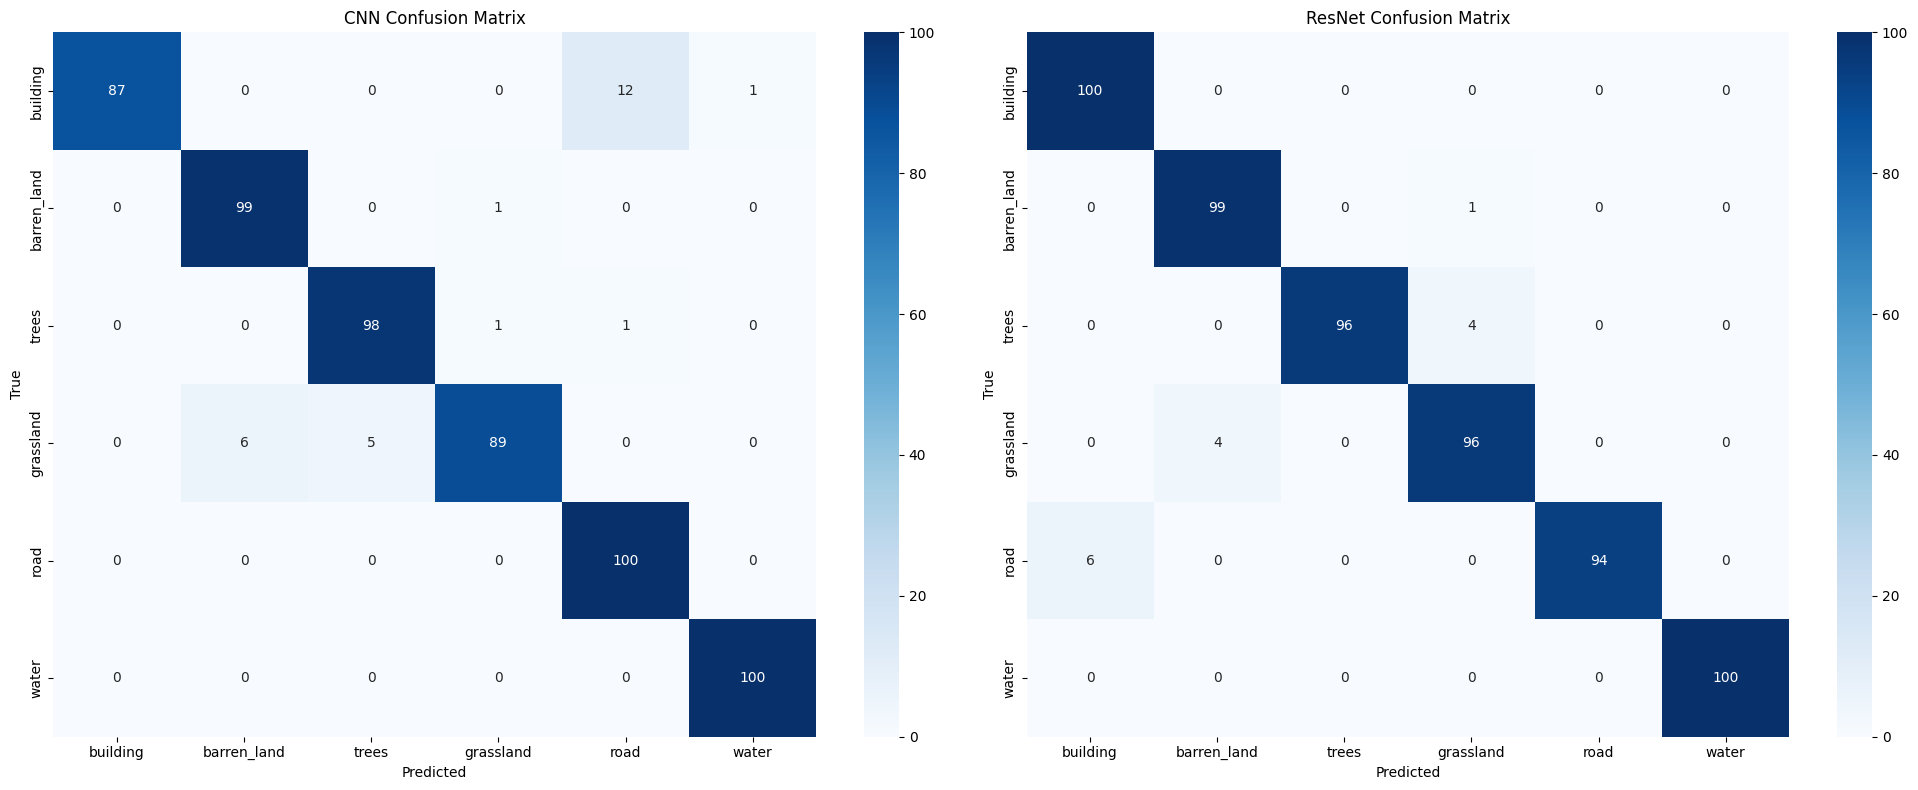


Total unique test images: 100

Samples per class in test set:
building: 17
barren_land: 17
trees: 16
grassland: 17
road: 17
water: 16


In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = annotations[0].values

# Define class labels for better readability
# Create figure with two subplots side by side
plt.figure(figsize=(20,8))

# CNN Confusion Matrix
plt.subplot(1,2,1)
cm_cnn = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# ResNet Confusion Matrix
plt.subplot(1,2,2)
cm_resnet = confusion_matrix(resnet_true_labels, resnet_pred_labels)
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('ResNet Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

# Print some summary statistics
true_labels_np = np.array(true_labels)

# Get unique test samples by taking every 6th value 
# (since each image is evaluated 6 times, once for each class)
unique_labels = true_labels_np[::6]

print("\nTotal unique test images:", len(unique_labels))
print("\nSamples per class in test set:")
for i, name in enumerate(labels):
    print(f"{name}: {np.sum(unique_labels == i)}")


Conclusion: the model is (too) accurate, it has an easy time separating classes because its features are distinct, rarely overlap, and can be captured by both model architectures accurately. For example, water might be easily distinguishable when looking at the NIR channel. Then, vegetation is also easily distinguishable, in our false color plot it is bright red. Buildings and roads specifically may be harder to distinguish visually, which is definitely something we also see in our final confusion matrices. Barren land is easy to classify because of its plain texture but distinct color scheme, similar to grassland. However, for the grassland <-> trees separation, the colors might be less important than the clear distinction through texture. We can also see this in our confusion matrix. Finally, ResNet seems to capture features even faster; training for 1 epoch could even be enough, but in this example also the CNN converges quickly after around 7 epochs to ResNet's performance as we see in the training metrics plots. The ROC plots do not yield much insight, because the models are both too good. One can still see that ResNet is just slightly better; we used the one-vs-rest approach for ROC because we do not just have binary classification here.